In this notebook I test the data analysis algorithm (which I previously built and retested on the synthetic dataset) on the real data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from matplotlib.backends.backend_pdf import PdfPages
from scipy import stats
from sklearn.decomposition import NMF

## Preprocessing the data:

In [2]:
movie_data = np.load('folder/3.npy')

In [3]:
np.shape(movie_data)

(1000, 512, 512)

Text(0.5, 1.0, 'Total view of the movie data')

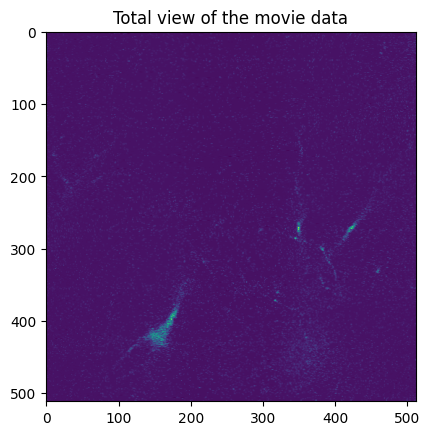

In [4]:
plt.imshow(movie_data[1, 0:512, 0:512])
plt.title('Total view of the movie data')

In [5]:
cropped_movie_data = movie_data[0:1000, 200:512, 300:512]

In [6]:
ROIsoma_movie = cropped_movie_data[0:1000, 190:290, 0:100]
ROIdendrite_A_movie = cropped_movie_data[0:1000, 0:100, 0:100]
ROIdendrite_B_movie = cropped_movie_data[0:1000, 25:125, 90:190]

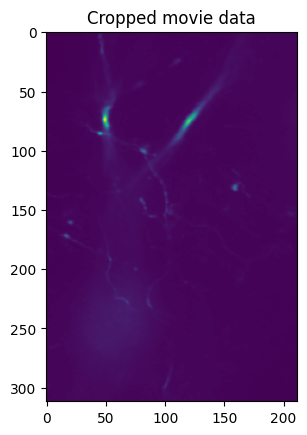

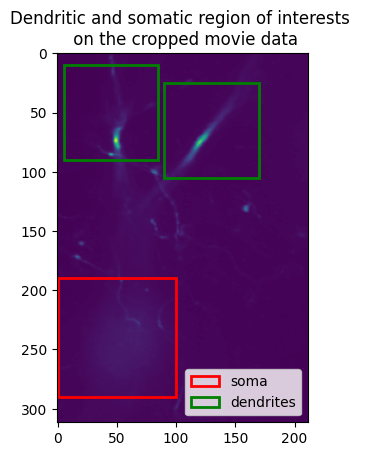

In [7]:
mean_img = np.mean(cropped_movie_data, axis = 0)
plt.imshow(mean_img)
plt.title('Cropped movie data')
  
# Create figure and axes
fig, ax = plt.subplots(1)
  
# Display the image
ax.imshow(mean_img)
  
# Create a Rectangle patch
rect_one = patches.Rectangle((0, 190), 100, 100, linewidth=2,
                         edgecolor='r', facecolor="none")

rect_two = patches.Rectangle((5, 10), 80, 80, linewidth=2,
                         edgecolor='g', facecolor="none")

rect_three = patches.Rectangle((90, 25), 80, 80, linewidth=2,
                         edgecolor='g', facecolor="none")
  
# Add the patch to the Axes
ax.add_patch(rect_one)
ax.add_patch(rect_two)
ax.add_patch(rect_three)
ax.set_title('Dendritic and somatic region of interests \n on the cropped movie data')
ax.legend(['soma', 'dendrites'])
plt.show()

## Data analysis - creating transient profiles:

In [10]:
def create_spatial_transient_profiles(soma_ROI_movie_data, dendrite_ROI_movie_data, 
                                      beta_loss = 'kullback-leibler', max_iter = 5000,
                                      alpha_W = 0.0011, alpha_H = 0.0017, l1_ratio = 0.5,
                                      sigma = 0.5, theta_upper = 1.65, theta_lower = 1.6,
                                      offset = 50, w_seq = 4, title = '{0}. dendritic transient', filename = ''):
    
    # Extracting source profiles and fluorescent signals by non-negative matrix factorization:
    # - Soma NMF:
    soma_x, soma_y, soma_z = np.shape(soma_ROI_movie_data)
    
    if soma_z > soma_x:
        try:
            soma_matrix = soma_ROI_movie_data.reshape(soma_z,soma_y*soma_x)
        except ValueError as pokpok:
            print("Invalid shape")
            raise pokpok
    else:
        soma_matrix = soma_ROI_movie_data.reshape(soma_x,soma_y*soma_z)
        
    soma_matrix = soma_matrix.transpose()
    
    soma_model = NMF(n_components = 1, init = 'random', random_state = 0, solver = 'mu', beta_loss ='kullback-leibler', max_iter = 5000, alpha_W = 0.0011, alpha_H = 0.0017, l1_ratio = 0.5)# multiplicative addtion and Kullback-Leibler divergence
    soma_W = soma_model.fit_transform(soma_matrix)
    soma_H = soma_model.components_
    
    soma_fluorescent_signal = soma_H.reshape(1*soma_x)
    soma_fluorescent_signal = (soma_fluorescent_signal - np.median(soma_fluorescent_signal)) / np.median(soma_fluorescent_signal)
    
    # - Dendrite NMF:
    dendrite_x, dendrite_y, dendrite_z = np.shape(dendrite_ROI_movie_data)
    
    if dendrite_z > dendrite_x:
        try:
            dendrite_matrix = dendrite_ROI_movie_data.reshape(dendrite_z,dendrite_y*dendrite_x)
        except ValueError as pokpok:
            print("Invalid shape")
            raise pokpok
    else:   
        dendrite_matrix = dendrite_ROI_movie_data.reshape(dendrite_x,dendrite_y*dendrite_z)
        
    dendrite_matrix = dendrite_matrix.transpose()
    
    dendrite_model = NMF(n_components = 1, init = 'random', random_state = 0, solver = 'mu', beta_loss = 'kullback-leibler', max_iter = 5000, alpha_W = 0.0011, alpha_H = 0.0017, l1_ratio = 0.5)# multiplicative addtion and Kullback-Leibler divergence
    dendrite_W = dendrite_model.fit_transform(dendrite_matrix)
    dendrite_H = dendrite_model.components_
    
    source_profile = dendrite_W.reshape(dendrite_y,dendrite_z)
    dendrite_fluorescent_signal = dendrite_H.reshape(1*dendrite_x)
    dendrite_fluorescent_signal = (dendrite_fluorescent_signal - np.median(dendrite_fluorescent_signal)) / np.median(dendrite_fluorescent_signal)
    
    # signal arrays must be padded before implementing convolution to preserve the index of the original signal transient events
    def preprocess_for_conv(signal_for_gauss, kernel_length):
        N = len(signal_for_gauss)
        if (kernel_length % 2) == 0:
            return ('Kernel length is even.')
        K = int((kernel_length - 1)/2) # must be even in order to have the target data point at the middle
        new_arr = np.zeros(N + 2*K) 
        signal_start = signal_for_gauss[0]
        signal_end = signal_for_gauss[-1]
        new_arr[0:K] =  signal_start
        new_arr[-K:] = signal_end
        new_arr[K:(N+K)] = signal_for_gauss
        return new_arr
    
    soma_fluorescent_signal = preprocess_for_conv(soma_fluorescent_signal, 15)
    dendrite_fluorescent_signal = preprocess_for_conv(dendrite_fluorescent_signal, 15)
    
    # Signal smoothing
    x = np.arange(-7,8,1)
    sigma = 0.5
    normal = 1 / (2.0 * np.pi * sigma**2)
    gauss_kernel_beta =  np.exp(-((x**2) / (2.0*sigma**2))) * normal
    gauss_kernel = gauss_kernel_beta / np.sum(gauss_kernel_beta)
    
    soma_fluorescent_signal = np.convolve(soma_fluorescent_signal, gauss_kernel,mode = 'valid')
    dendrite_fluorescent_signal = np.convolve(dendrite_fluorescent_signal, gauss_kernel, mode = 'valid')
    
    # Event detection:
    signal = dendrite_fluorescent_signal
    N = len(dendrite_fluorescent_signal)
    event = np.zeros(N)
    transient = np.zeros(N)
    start_end = []
    
    refr = 0
    start_end_i = np.zeros(2)
    
    for i in np.arange(1,N):
        if ((signal[i] > theta_upper) and (signal[i-1] < theta_upper) and (refr == 0)):
            event[i] = 1 
            refr = 1
            start_end_i[0] = i
        if ((signal[i]<theta_lower) and (signal[i-1]>theta_lower) and (refr == 1)):
            refr = 0
            start_end_i[1] = i
            start_end.append(start_end_i)
            start_end_i = np.zeros(2)
        if (refr == 1):
            transient[i] = 1
    if ((start_end_i[0] > 0) & (start_end_i[1] == 0)):
        start_end_i[1] = N
        start_end.append(start_end_i)
        
    
    start = np.array(start_end)[:,0].astype(int)
    end = np.array(start_end)[:,1].astype(int)
    
    
    # Transient profiles:
    transient_profs = []
    l=len(start)
    for j in range(l):
        
        transient_signal = signal
        movie_tensor = dendrite_ROI_movie_data
        index = np.arange(start[j]-5, end[j]+5)
        index_len = np.arange(0,len(index),1)
        transient = transient_signal[index]
        movie_tensor = movie_tensor[index,:,:]
        Y = transient[:, np.newaxis, np.newaxis] * movie_tensor
        transient_pic = np.sum(Y[index_len,:,:],axis=0)
        normalized_trans_pic = transient_pic/sum(transient**2)
        transient_prof = normalized_trans_pic
        transient_profs.append(transient_prof)
    
    dendrite_signal = dendrite_fluorescent_signal
    soma_signal = soma_fluorescent_signal
    dendrite_source_profile = source_profile
    index_start = start
    index_stop = end
    transient_profiles = transient_profs
    
    
    # Plotting transient profiles:
    l = len(np.array(index_start))
    for k in range(l):
        
        transient_profile = transient_profiles[k]
        cor = np.round(np.corrcoef(transient_profile, source_profile)[0][1], 3)
        
        interval_min = offset 
        interval_max = interval_min + (index_stop[k]-index_start[k]) + 1
        
        # time-scale parameters
        len_signal = len(dendrite_signal)
        len_signal = len_signal*w_seq
        current = 112*w_seq
        time_len_s = round(current/len_signal,2)
        start_point = index_start[k]-offset
        start_point = start_point+len_signal
        end_point = index_stop[k]+offset
        end_point = end_point+len_signal
        time_interval = round((end_point-start_point)/5)
        lbls = [i*time_len_s for i in list(range(start_point, end_point, time_interval))] #start_point
        lbls = [round(num, 1) for num in lbls]
        tcks = list(range(0, end_point-start_point, time_interval))
        
        fig = plt.figure(k)
        fig.set_figheight(15)
        fig.set_figwidth(20)
        
        plt.subplots_adjust(hspace=0.5)
        
        rows = 2
        columns = 2
        
        fig.add_subplot(rows, columns, 1)
        plt.imshow(dendrite_source_profile)
        plt.title('A - Source profile \n ', fontsize = 20)
        plt.axis('off')
        
        ax = fig.add_subplot(rows, columns, 2)
        ax.imshow(transient_profile)
        
        plt.title('B - Transient profile \n r = {0}'.format(cor), fontsize = 20)
        plt.xticks(color = 'w')
        plt.yticks(color = 'w')
        
        color = "red" if cor > 0.7 else "white"
        for x in ["top","left","right","bottom"]:
            ax.spines[x].set_color(color)
            ax.spines[x].set_linewidth(8)
            
        # DF/F signals    
        fig.add_subplot(rows, columns, 3)
        plt.plot(soma_signal[index_start[k]-offset:index_stop[k]+offset], 'k')
        plt.title('somatic dF/F signal', fontsize = 20)
        plt.xlabel('Time (s)', fontsize = 15)
        plt.ylabel('Amplitude', fontsize = 15)
        plt.ylim(-0.1, 0.5)
        plt.xticks(ticks = tcks*w_seq, labels = lbls*w_seq, fontsize = 15)
        plt.axvspan(interval_min, interval_max, color = 'moccasin', alpha=0.7)
        
        fig.add_subplot(rows, columns, 4)
        plt.plot(dendrite_signal[index_start[k]-offset:index_stop[k]+offset], 'k')
        plt.title('dendritic dF/F signal', fontsize = 20)
        plt.xlabel('Time (s)', fontsize = 15)
        plt.ylabel('Amplitude', fontsize = 15)
        plt.ylim(-0.1, 0.5)
        plt.xticks(ticks = tcks*w_seq, labels = lbls*w_seq, fontsize = 15)
        plt.yticks(fontsize = 15)
        plt.axvspan(interval_min, interval_max, color = 'moccasin', alpha=0.7)
        
        title_num = 1
        title_num = title_num + k
        
        fig.suptitle(title.format(title_num), fontsize=20, weight = 'bold')
        
        pdf_pages = len(index_stop)
        
        with PdfPages(filename) as pdf:
            for fig in range(pdf_pages):
                plt.figure(fig)
                pdf.savefig(bbox_inches = "tight")             

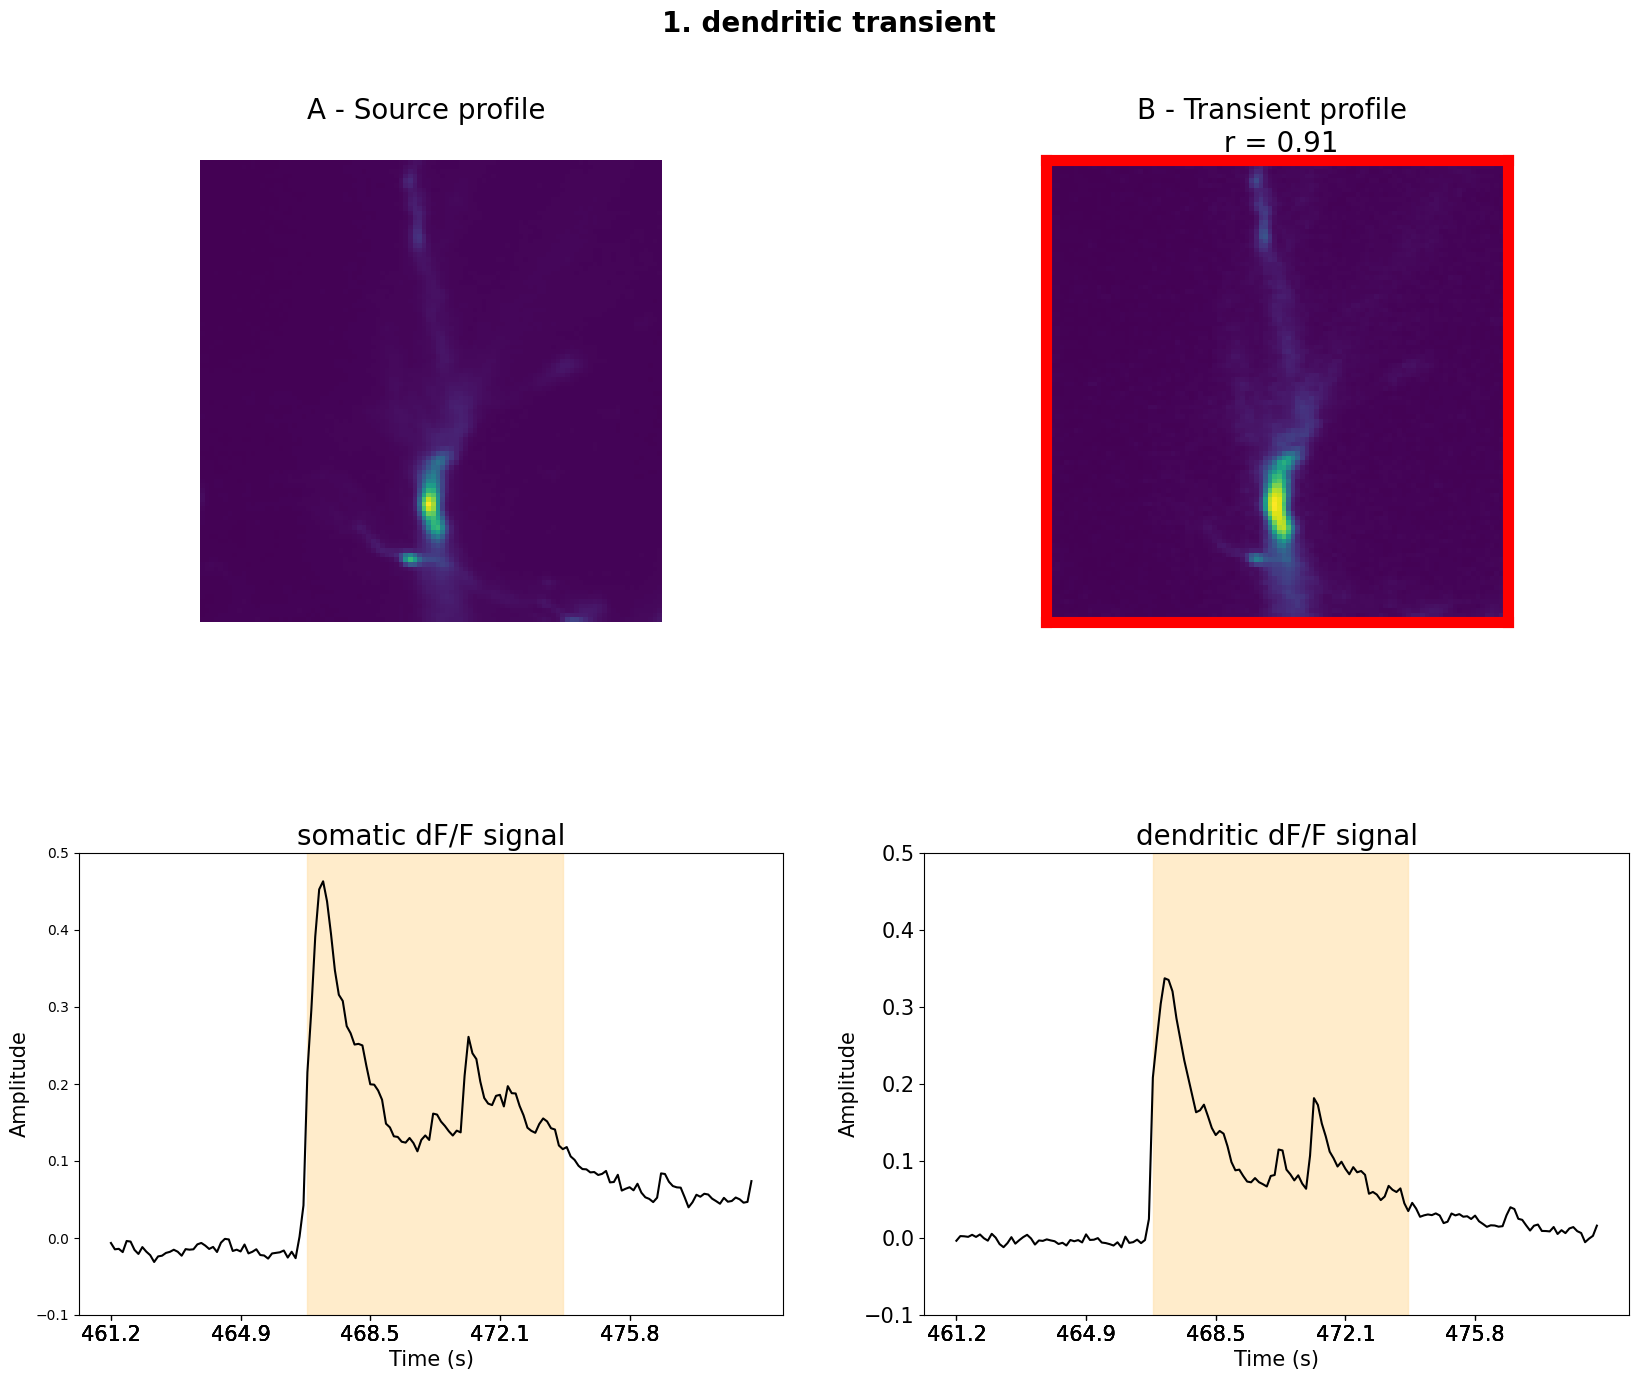

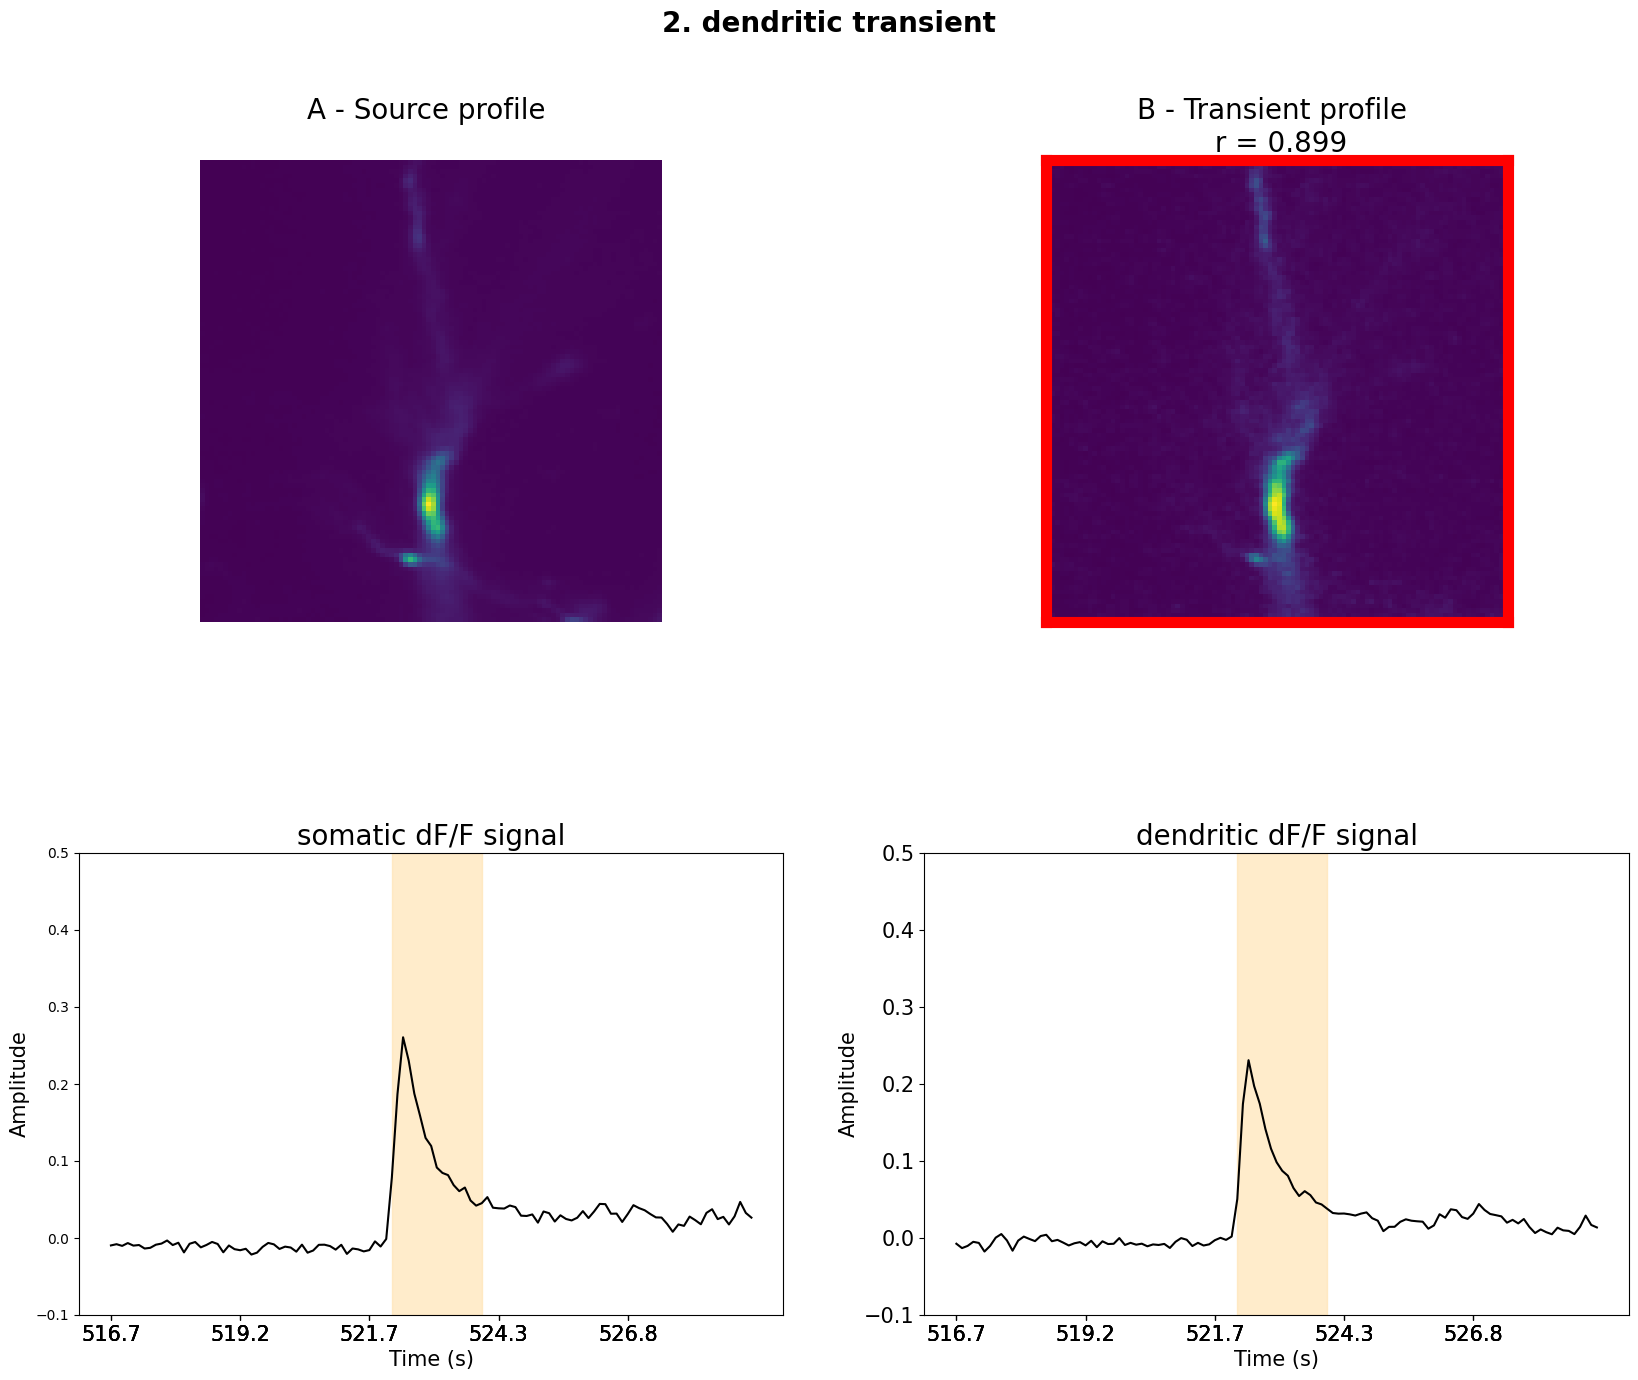

In [11]:
create_spatial_transient_profiles(ROIsoma_movie, ROIdendrite_A_movie,
                                  'kullback-leibler', 5000,
                                  0.0011, 0.0017, 0.5,
                                  0.5, 0.05, 0.045,
                                  50, 4,'{0}. dendritic transient', '3. recording sequence, dendritic events - 4. ROI.pdf')